In [19]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import torch
import networkx as nx
import json
import copy
import gzip
import pickle
from collections import Counter

from crp.image import imgify

from helper import get_dr_methods, to_name, init_experiment
from plotting import draw_graph_with_images, data_iterations, plot_accuracies, my_plot_grid, plot_fancy_distribution
from network import load_model
from test_dataset import TestDataset
from crp_attribution import CRPAttribution
from wdsprites_dataset import BackgroundDataset, BiasedNoisyDataset


%reload_ext autoreload
%autoreload 2


plt.rcParams['text.usetex'] = True
mpl.rcParams.update({'font.family': 'serif', "font.size": 20})

In [20]:
EXPERIMENT = 1
(
    sample_set_size,
    iterations,
    LAYER_NAME,
    is_random,
    MODEL_PATH,
    EXPERIMENT_NAME,
    MODEL_TYPE,
    Datasettype,
    mask,
    ACCURACYPATH,
    relsetds,
) = init_experiment(EXPERIMENT)

In [21]:
# LOAD ONE MODEL, EXPERIMENT, BIAS AND SEED ARE ADJUSTABLE
MAX_INDEX = 491519
BIAS = 1.0
BIASES = list(np.round(np.linspace(0, 1, 51), 3))
BIAS_IND = BIASES.index(BIAS)
NUM_IT = 4
model = load_model(MODEL_PATH, BIAS, NUM_IT, model_type=MODEL_TYPE)
model_name_crpa = f"{MODEL_TYPE}_{to_name(BIAS, NUM_IT)}_vis"

if EXPERIMENT == 1:
    fullds = BiasedNoisyDataset(0.0, 0.5)
else:
    fullds = BackgroundDataset(0.0, 0.5)
    
ds = TestDataset(length=300, experiment=MODEL_TYPE)
crpa = CRPAttribution(model, ds, MODEL_PATH, model_name_crpa, max_target="sum")

# UNCOMMENT THIS IF REFERENCE SETS ALREADY COMPUTED
res = crpa.compute_feature_vis()

feature vis is computed


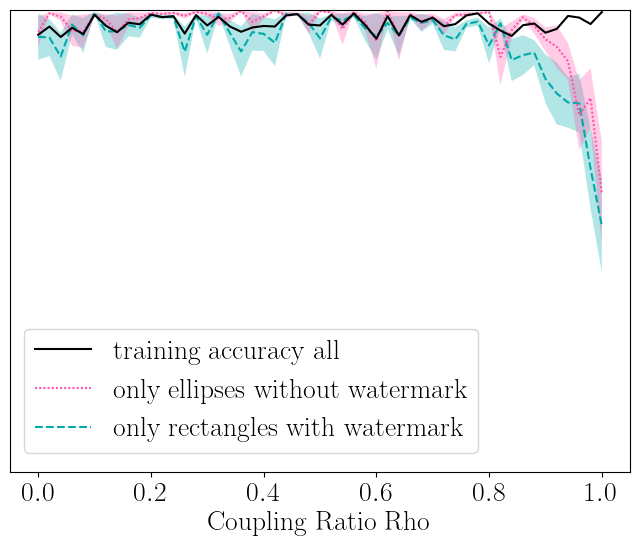

In [22]:
# GENERAL ACCURACY
A = "outputs/accuracies_watermark.json"
B = "outputs/accuracies_pattern.json"

bad_biases = plot_accuracies(
    ACCURACYPATH, 90, num_it=16, intervened=True, istop=False, isleft=False
)

datas, bis, biases, alldata = data_iterations(ACCURACYPATH, num_it=16)

/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/crp/image.py:288: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


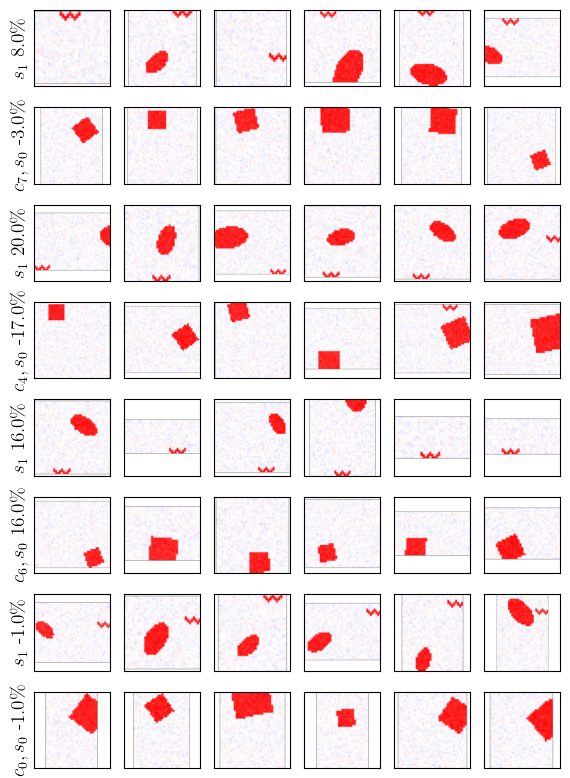

In [23]:
# CLASS SPECIFIC REFERENCE SETS OF SELECTED NEURONS
rels, pred, label, wm = crpa.relevances_of_layer(101, False, LAYER_NAME)
rels1 = torch.round(rels, decimals=2)

rels, pred, label, wm = crpa.relevances_of_layer(195, False, LAYER_NAME)
rels0 = torch.round(rels, decimals=2)

""" import pickle
import gzip

filename = f"outputs/overlap_attribution/50_{num_it}.gz"
with gzip.open(filename, mode="rb") as f:
    r_m_info = pickle.load(f)
rels0 = r_m_info[2][:, 0].to(dtype=torch.float).mean(dim=0).view(1,8)
rels1 = r_m_info[2][:, 1].to(dtype=torch.float).mean(dim=0).view(1,8) """

relevances = torch.cat((rels1, rels0))
NEURONS = [7,4,6,0]#range(8)
mpl.rcParams.update({"font.family": "serif", "font.size": 14})
crpa.make_stats_references(LAYER_NAME, NEURONS, "relevance", relevances)

output: tensor([[-10.0175,  11.0711]]), 
 latents: [ 0  5  0 21 13], watermark: True, prediction:1 
 convolutional_layers.0: 
 0: -0.08, 1: 0.08, 2: -0.06, 3: 0.42, 4: 0.12, 5: 0.12, 6: -0.0, 7: -0.12 
 convolutional_layers.3: 
 0: -0.15, 1: -0.19, 2: -0.23, 3: -0.04, 4: 0.07, 5: 0.25, 6: -0.06, 7: -0.01 
 convolutional_layers.6: 
 0: 0.01, 1: -0.24, 2: 0.12, 3: 0.01, 4: 0.18, 5: 0.1, 6: 0.2, 7: 0.14 
 linear_layers.0: 
 0: 0.28, 1: -0.08, 2: -0.06, 3: 0.25, 4: 0.25, 5: -0.07 
 linear_layers.2: 
 0: -0.48, 1: 0.52 


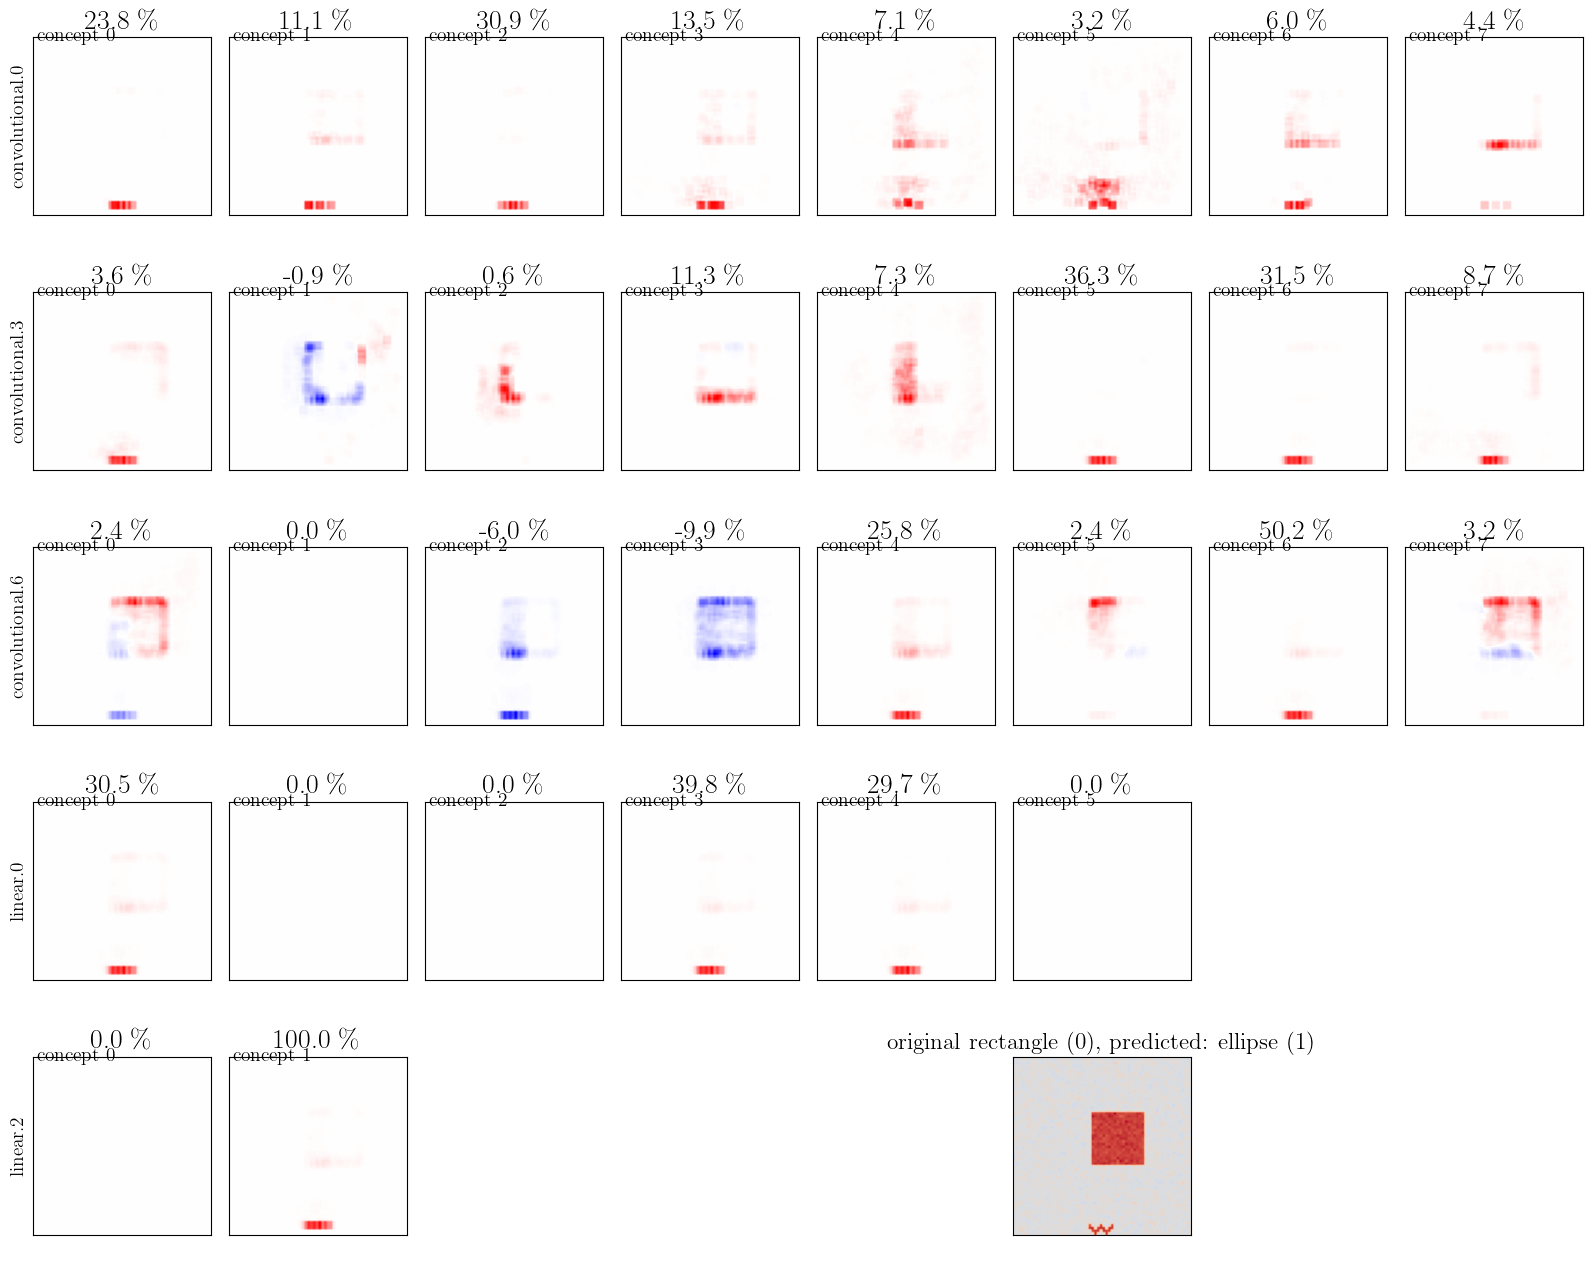

In [24]:
## VISUALIZE ATTRIBUTION MAPS FOR ALL NEURONS
res = crpa.image_info(125, verbose=True)

1 1


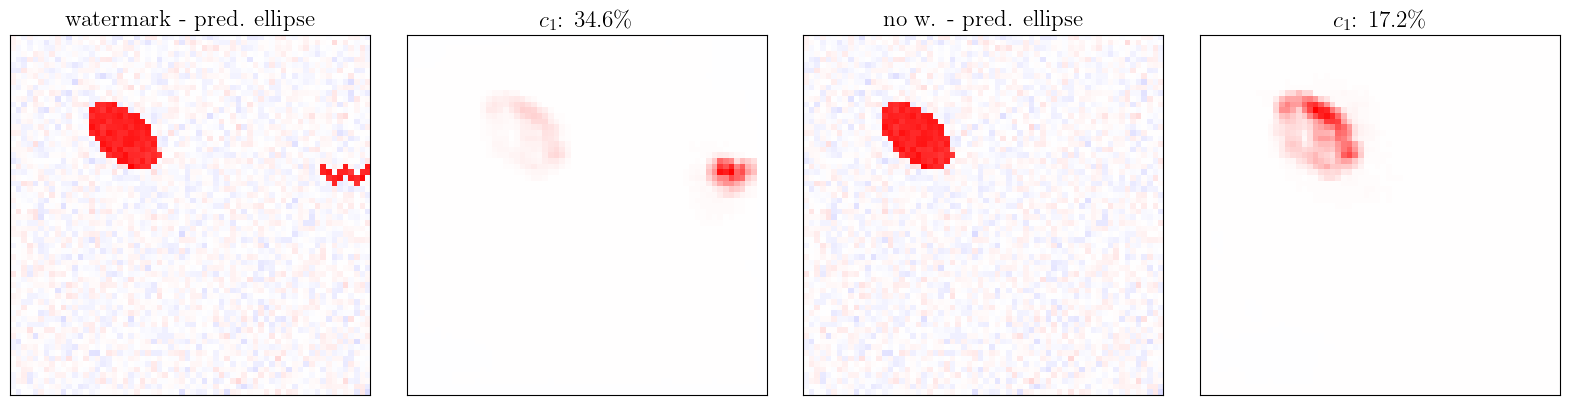

In [205]:
# EXAMPLE NON-ZERO RELEVANCE OUTSIDE WATERMARK AREA WHEN WATERMARK IS SUPER IMPORTANT

indf = 302210
neuron = 1
img = fullds.load_image_wm(indf, False)
hm, img, pred = crpa.heatmap_neuron(img, 4, LAYER_NAME)  # 179
img.requires_grad = False
hm.requires_grad = False

img1 = fullds.load_image_wm(indf, True)
hm1, img1, pred1 = crpa.heatmap_neuron(img1, 4, LAYER_NAME)  # 179
img1.requires_grad = False
hm1.requires_grad = False
print(pred, pred1)
my_plot_grid(
    torch.cat(
        (
            img1[0],
            hm1,
            img[0],
            hm,
        )
    ),
    1,
    4,
    norm=False,
    cmap="bwr",
    resize=5,
    titles=[
        "watermark - pred. ellipse",
        "$c_1$: 34.6\%",
        "no w. - pred. ellipse",
        "$c_1$: 17.2\%",
    ],
)

[['2.08\\%', '-1.75\\%'], ['0.0\\%', '0.0\\%'], ['0.25\\%', '-0.95\\%'], ['-36.15\\%', '36.49\\%'], ['1.24\\%', '-0.99\\%'], ['9.34\\%', '-7.53\\%'], ['-8.8\\%', '7.47\\%'], ['-42.15\\%', '44.81\\%']]


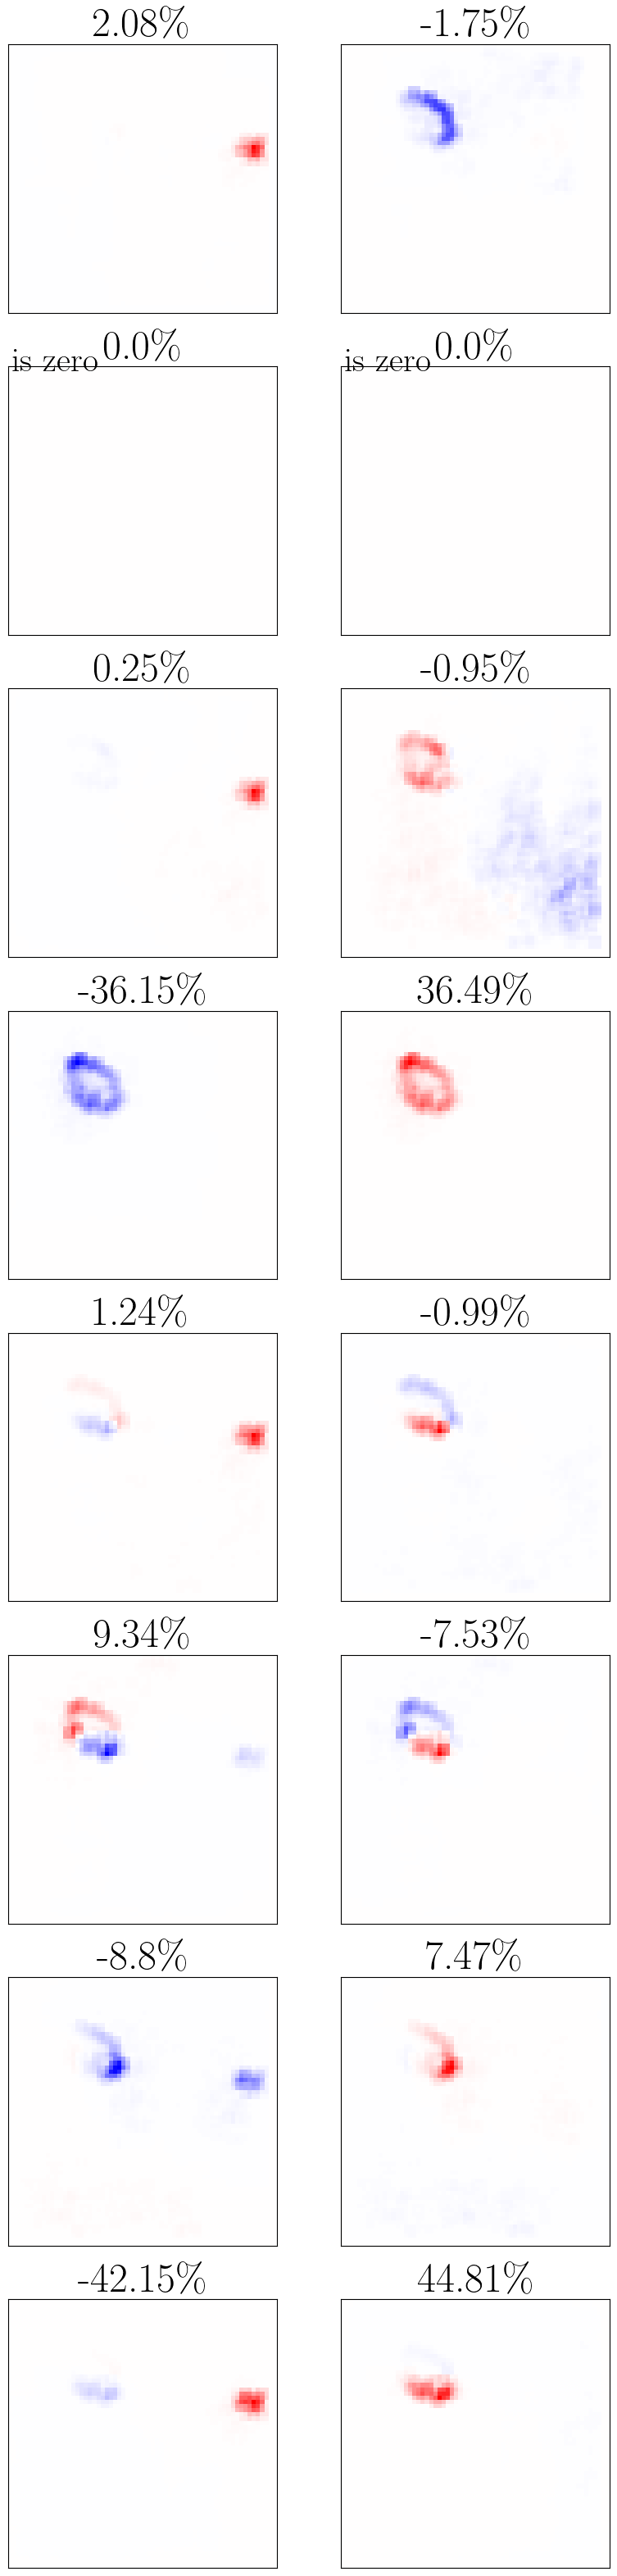

In [55]:

mpl.rcParams.update({'font.family': 'serif',  "font.size": 30})
indf = 302210
neuron = 1
hms = []
preds = []
img = fullds.load_image_wm(indf, False)
img1 = fullds.load_image_wm(indf, True)
relevances0 = crpa.relevance_layer(img, 0, LAYER_NAME)
relevances1 = crpa.relevance_layer(img, 1, LAYER_NAME)
rels = torch.zeros(8,2)
rels[:,0] = relevances1
rels[:,1] = relevances0
rels = [[f"{round(float(a[0])*100,2)}\%", f"{round(float(a[1])*100,2)}\%"] for a in rels]
print(rels)
for i in range(8):
    hm, img, pred = crpa.heatmap_neuron(img, i, LAYER_NAME)  # 179
    hm.requires_grad = False
    hm1, img1, pred1 = crpa.heatmap_neuron(img1, i, LAYER_NAME)  # 179
    hm1.requires_grad = False
    hms.append(hm1)
    hms.append(hm)
rhms = torch.cat(hms).view(8,2,64,64)

my_plot_grid(
    rhms,
    8,
    2,
    norm=False,
    cmap="bwr",
    resize=5,
    titles=rels,
)

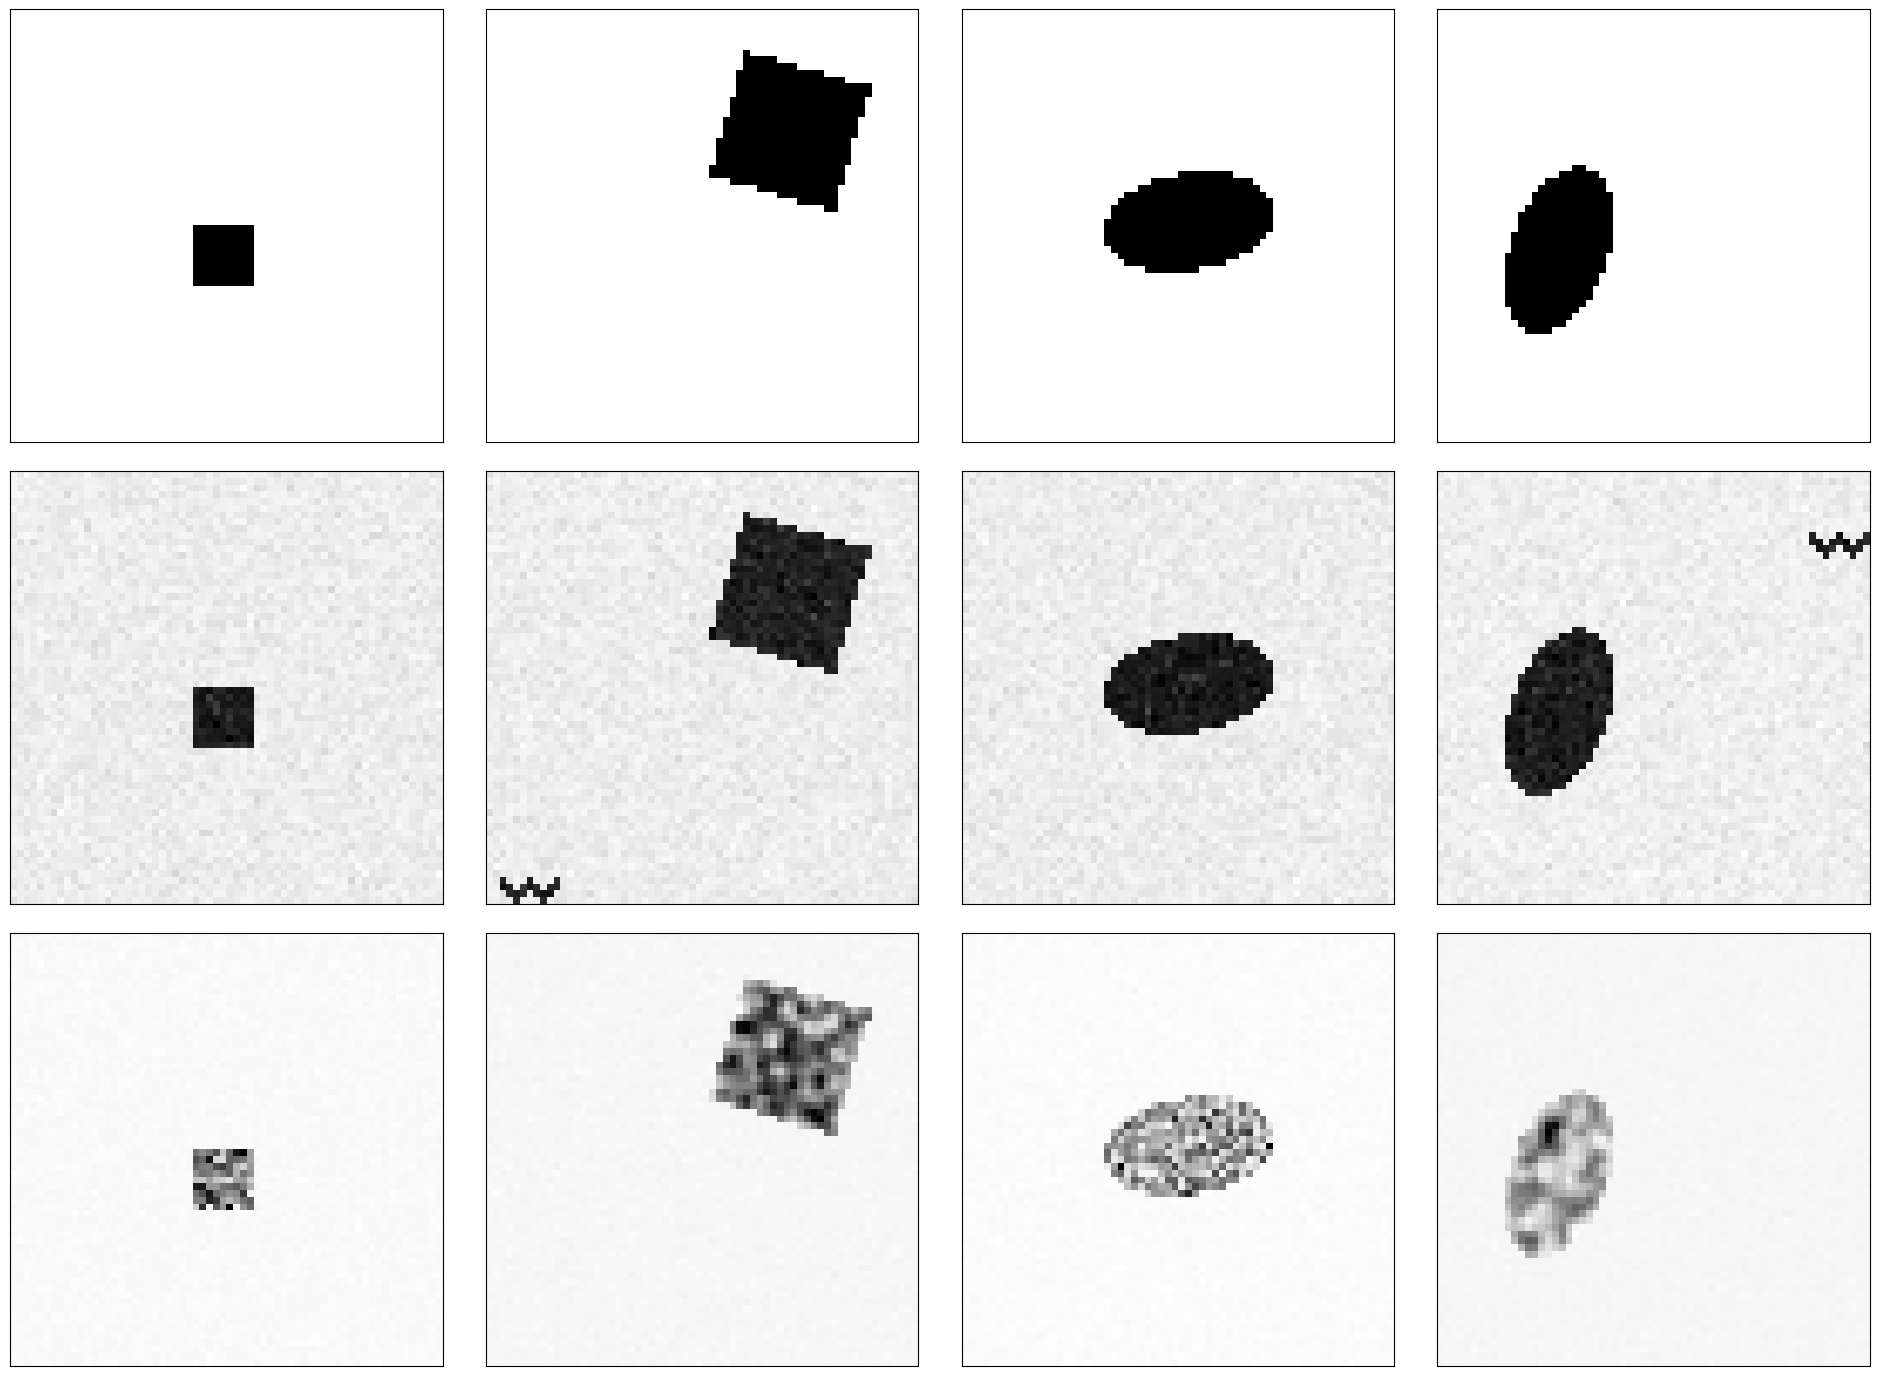

In [38]:
# Examples of Both Datasets
ds = BiasedNoisyDataset(0.0, 0.5)
bds = BackgroundDataset(0.0, 0.5)
imgs = torch.zeros(3,4,64,64)

imgs[0,0] = ds.load_shape_mask(500)[0,0]
imgs[0,1] = ds.load_shape_mask(213890)[0,0]
imgs[0,2] = ds.load_shape_mask(452143)[0,0]
imgs[0,3] = ds.load_shape_mask(478291)[0,0]
imgs[1,0] = ds.load_image_wm(500, False)
imgs[1,1] = ds.load_image_wm(213890, True)
imgs[1,2] = ds.load_image_wm(452143, False)
imgs[1,3] = ds.load_image_wm(478291, True)
imgs[2,0] = bds.load_image_wm(500, False)
imgs[2,1] = bds.load_image_wm(213890, True)
imgs[2,2] = bds.load_image_wm(452143, False)
imgs[2,3] = bds.load_image_wm(478291, True)
#imgs = imgs.view(8,64,64)
imgs = imgs.detach()
my_plot_grid(imgs, 3,4, resize=6)

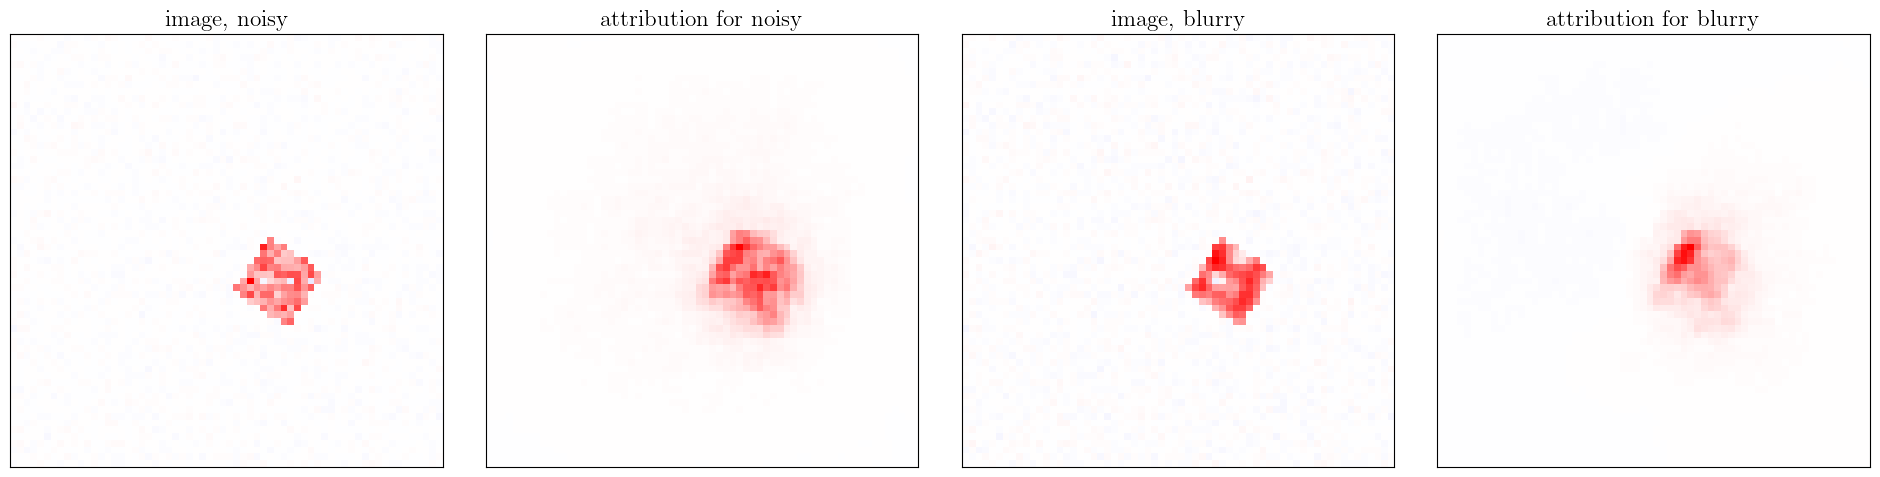

In [40]:
# EXAMPLE PATTERN ATTRIBUTION IS NOT DISTINGUISHABLE FROM SHAPE OR FROM ATTRIBUTION FOR DIFFERENT PATTERN CONCEPT
bds = BackgroundDataset(0.0, 0.5)
imgs = torch.zeros(4, 64, 64)
img1 = bds.load_image_wm(6900, False)
img2 = bds.load_image_wm(6900, True)

imgs[0] = img1
imgs[1] = crpa.heatmap_given_img(img1, 0)
imgs[2] = img2
imgs[3] = crpa.heatmap_given_img(img2, 0)
imgs = imgs.detach()
titles = ["image, noisy", "attribution for noisy", "image, blurry", "attribution for blurry"]
my_plot_grid(imgs, 1, 4, resize=6, norm=False, cmap="bwr", titles=titles)
#imgify(imgs.view(4,64,64),grid=(2,2), resize=600)

/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/crp/image.py:288: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


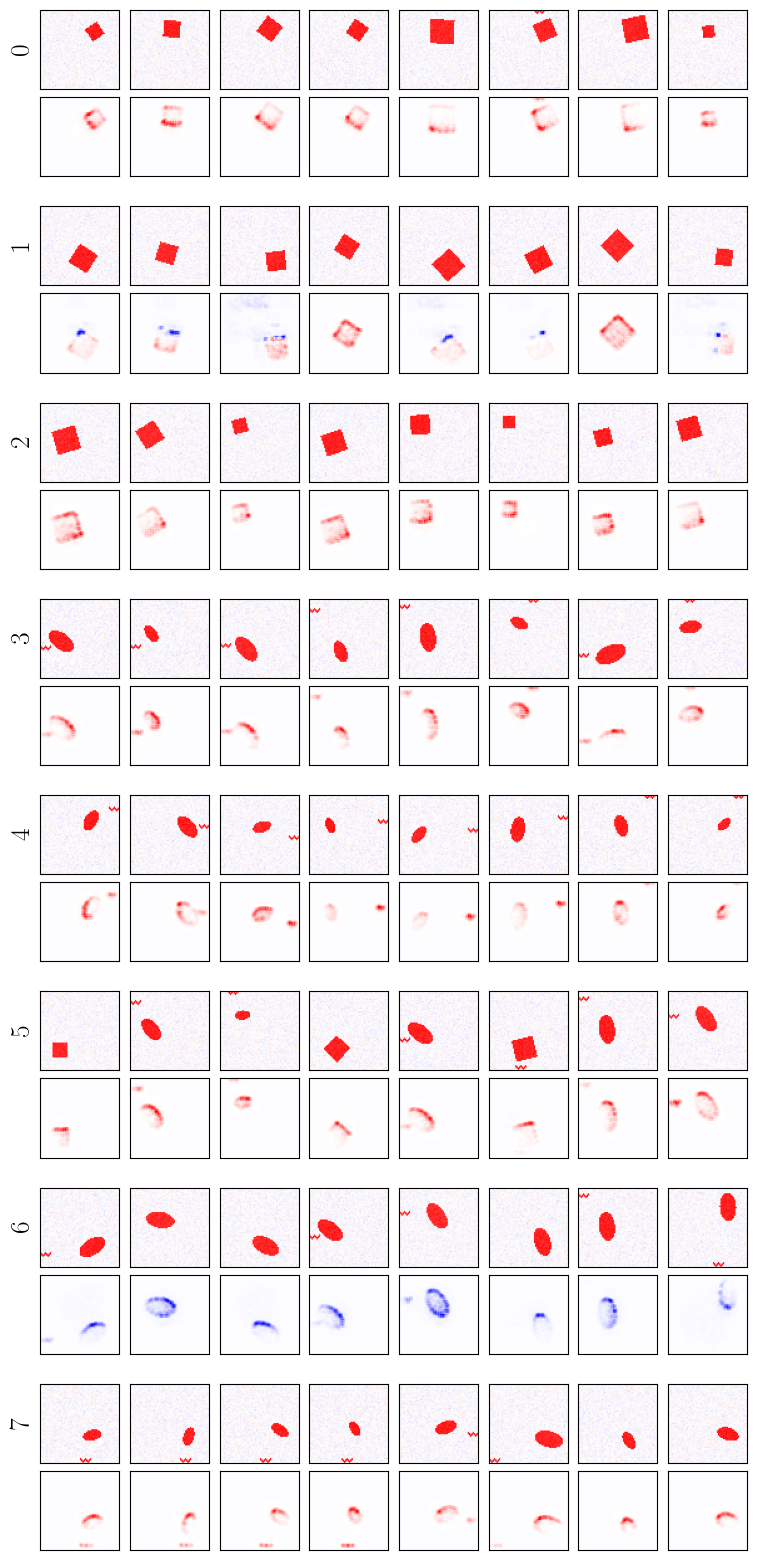

In [10]:
# EXAMPLE REFERENCE SET
neurons = range(8)
crpa.make_all_references(LAYER_NAME , neurons, relact="relevance") # activation

convolutional_layers.0 0 tensor(-21.7903) tensor(15360.7686)
convolutional_layers.3 1 tensor(-30.3629) tensor(2910.7178)
linear_layers.0 3 tensor(1.4641) tensor(2.6712)
linear_layers.2 4 tensor(-0.0939) tensor(0.1855)


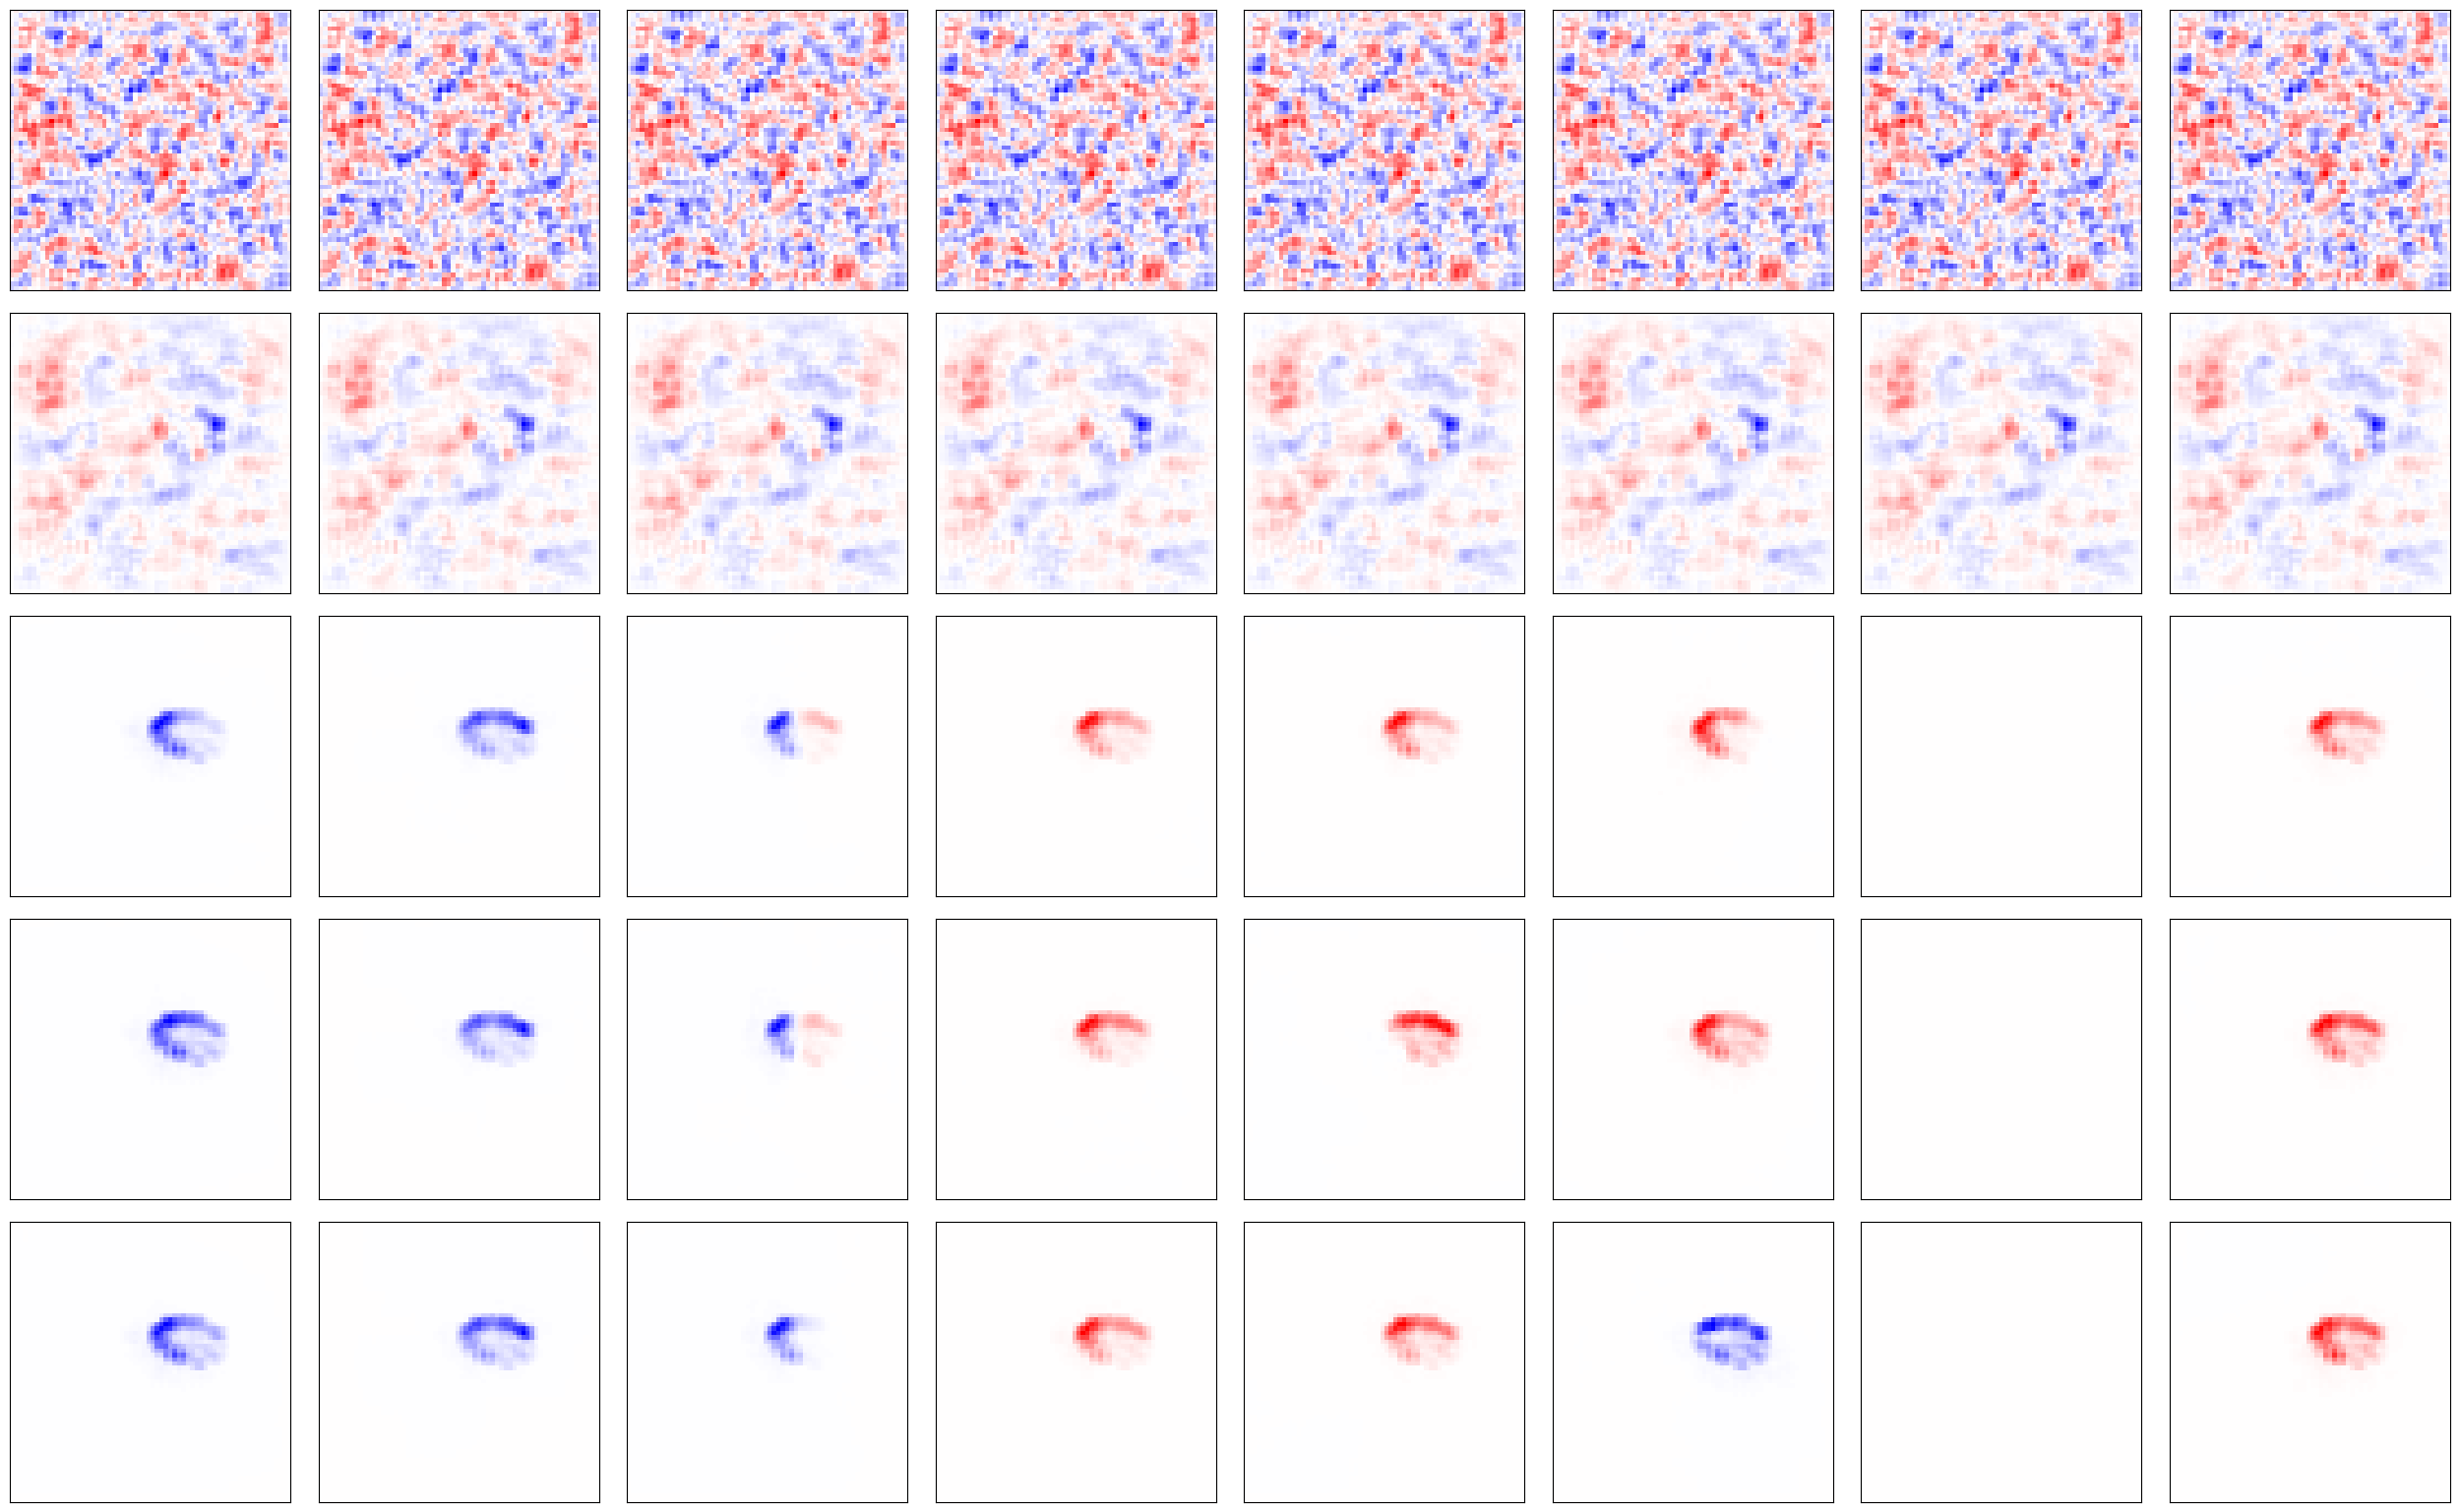

In [33]:
# SUCCESSIVE RANDOMIZATION OF LAYERS
image = fullds.load_image_wm(305931, False)
heatmaps = torch.zeros(5,8,64,64)
for li, l in enumerate(crpa.layer_id_map.keys()):
    if l != "convolutional_layers.6":
        random_init = torch.zeros(8,*crpa.output_shape[l])
        rand_init = torch.rand(crpa.output_shape[l]) * 2 -1
        random_init[:] = rand_init / rand_init.sum()
        res = crpa.attribution(
            image,
            [{"convolutional_layers.6": [i]} for i in range(8)],
            crpa.composite,
            record_layer=crpa.layer_names,
            start_layer=l,
            init_rel= random_init,
            exclude_parallel=False
        )
        heatmaps[li] = res.heatmap
        print(l, li, rand_init.sum(),rand_init.abs().sum())
    else: 
        res = crpa.attribution(
            image,
            [{"convolutional_layers.6": [i]} for i in range(8)],
            crpa.composite,
            record_layer=crpa.layer_names,
            start_layer="linear_layers.2",
            exclude_parallel=False
        )
        heatmaps[li] = res.heatmap

my_plot_grid(heatmaps, 5,8, 4, norm=False)

In [161]:
image = copy.deepcopy(fullds[260][0])
mask = fullds.load_watermark_mask(260)
img = torch.zeros(64,64,3)
img[:,:,1] = (image[0] * -1) + 0.5
img[:,:,2] = (image[0] * mask * -1) + 1
img[np.where(mask == 1)[0],np.where(mask == 1)[1],0] = 1
img = (img - img.min()) / img.max()
plt.imshow(img, cmap="gray")
plt.axis("off")

FileNotFoundError: [Errno 2] No such file or directory: '../dsprites-dataset/images/260.npy'

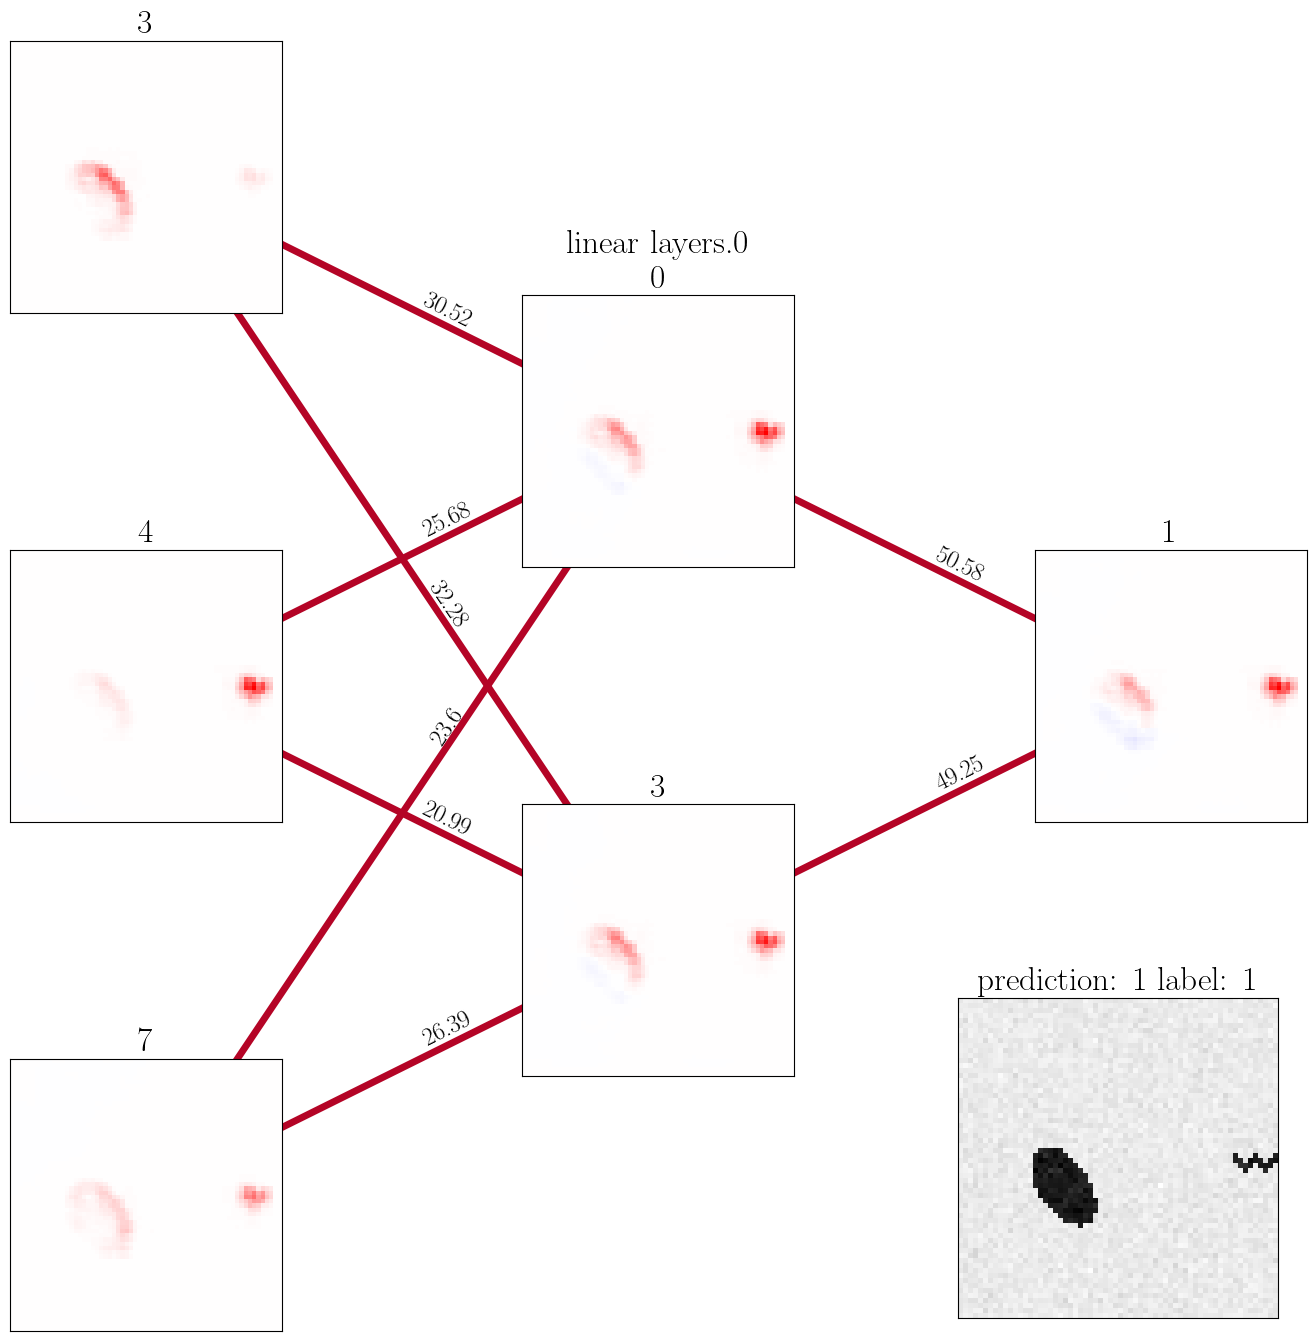

In [34]:
index = 220

nodes, edges, images = crpa.complete_relevance_graph(index)
draw_graph_with_images(nodes, edges, images)

Counter({-1: 2880, 3: 326, 4: 318, 7: 289, 1: 283})


(-0.5, 63.5, 63.5, -0.5)

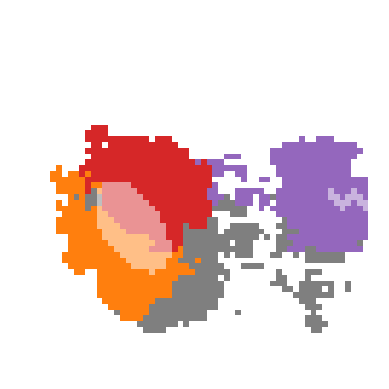

In [32]:
# CONCEPT ATLAS
chms = torch.zeros(8, 64, 64)
for neuron in range(8):
    chms[neuron] = images[f"convolutional_layers.6_{neuron}"][
        0
    ]  # convolutional_layers.6 linear_layers.0

maxact = torch.max(chms.abs(), dim=0)
concept_atlas = torch.where(maxact.values.abs() <= 0.0001, 0, maxact.indices + 1)
print(Counter((concept_atlas - 1).flatten().tolist()))
COLORS = [
    (1, 1, 1),
    (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
    (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
    (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
    (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
    (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
    (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
    (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
    (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0),
    (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0),
    (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0),
]


cm = mpl.colors.ListedColormap(COLORS)

img = cm(concept_atlas)
realimg = images["original"][0] > 0.5
img[:, :, 3] -= 0.5 * realimg
plt.imshow(img)
plt.axis("off")

(-0.5, 9.5, 1.5, -0.5)

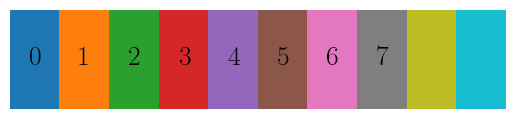

In [14]:
# CONCEPT ATLAS LEGEND
gradient = np.linspace(0, 1, 10)
gradient = np.vstack((gradient, gradient))
res = plt.imshow(gradient, cmap="tab10")
print()
for i in range(8):
    plt.text( i- 0.1,0.6, str(i))
plt.axis("off")

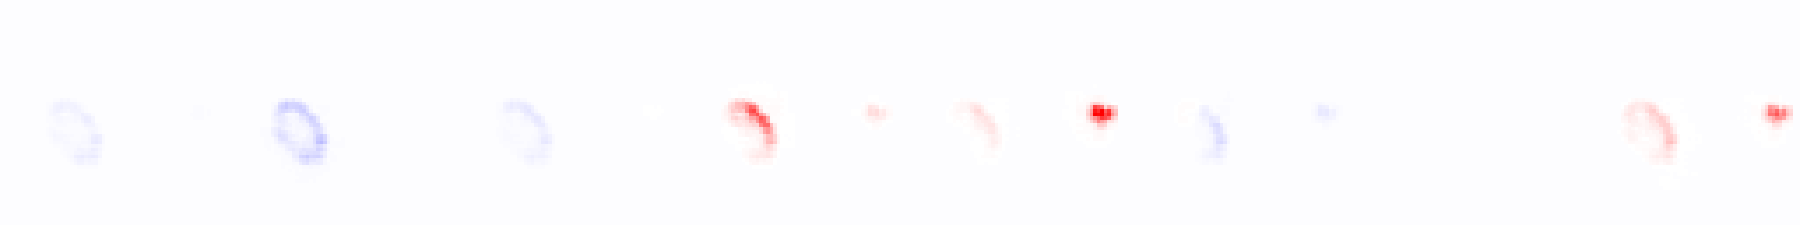

In [37]:
# HEATMAPS FOR CONCEPT ATLAS CONCEPTS
imgify(chms, resize=1800,vmax=.1,vmin=-0.1, grid=(1,8))

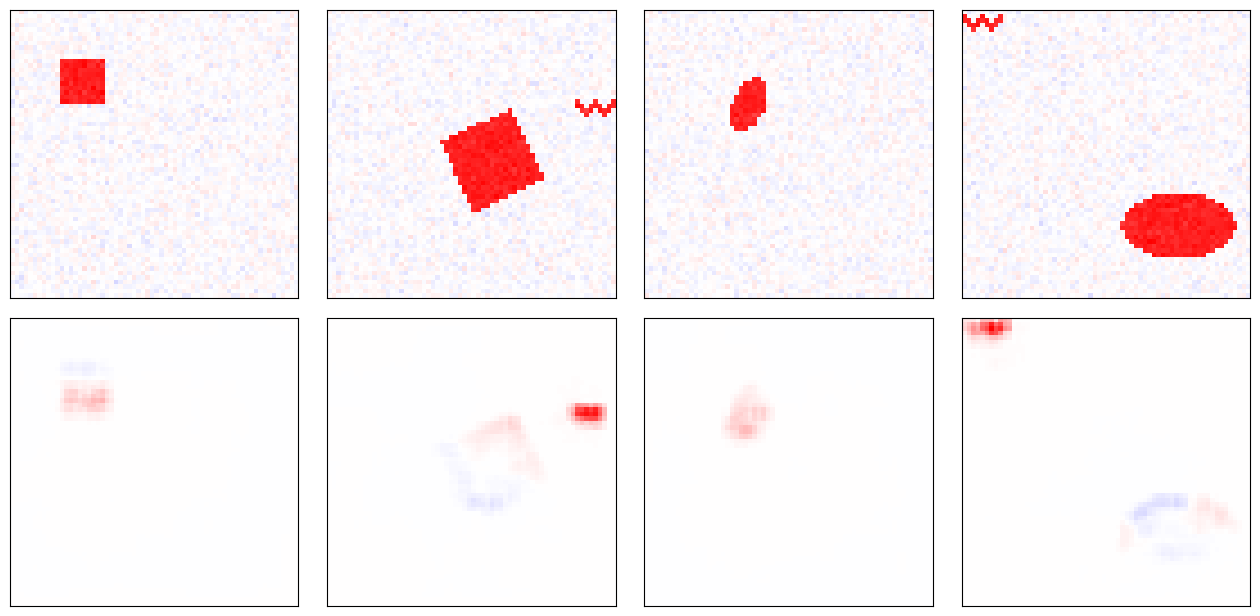

In [13]:
# HEATMAPS FOR SOME SAMPLE IMAGES
images = torch.zeros(2, 4, 64, 64)
for i, index in enumerate([0, 120, 154, 299]):
    images[0, i] = ds[index][0]
    images[1, i], pred = crpa.heatmap(index)

my_plot_grid(images, 2, 4, resize=4, norm="rows", cmap="bwr")

000 -> median: tensor([-18.1319,  -0.8648])
011 -> median: tensor([15.8578,  0.3441])
001 -> median: tensor([-16.6376,  -0.6539])
100 -> median: tensor([-18.0228,  -1.2520])
111 -> median: tensor([15.4263,  0.5739])
101 -> median: tensor([-20.6287,   1.5824])
EMPTY: lab 0, pred 1, wm 0, count 0.0
EMPTY: lab 1, pred 1, wm 0, count 0.0


Text(0.5, 1.0, 'Bias: 1.0, Method: tsne')

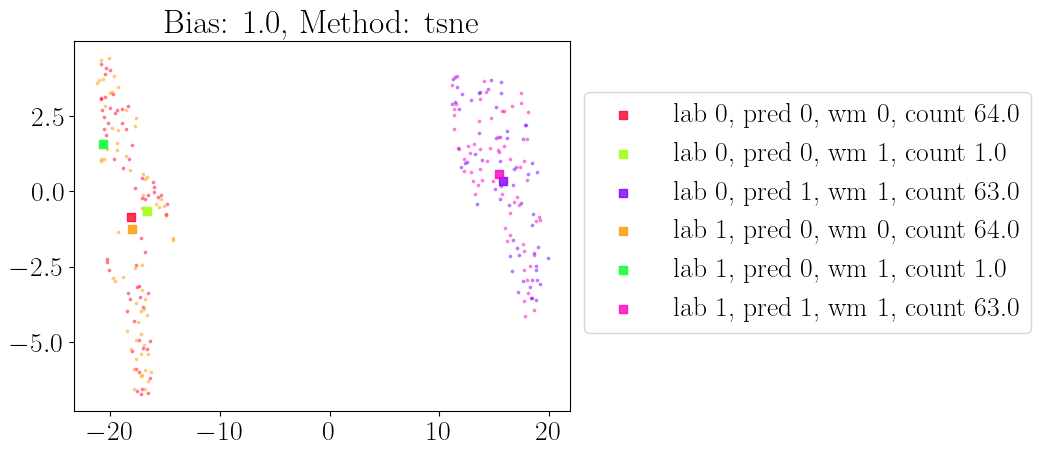

In [14]:
# DIMENSIONALITY REDUCTION OF RELEVANCE VECTORS

methods, names = get_dr_methods()
path = f"outputs/{EXPERIMENT_NAME}/{BIAS_IND}_{NUM_IT}.gz"

with gzip.open(path, "rb") as f:
    data = pickle.load(f)
    rels0 = data[2][:, 0].to(dtype=torch.float)
    rels1 = data[2][:, 1].to(dtype=torch.float)
    preds0 = data[3][:, 0].to(dtype=torch.float)
    preds1 = data[3][:, 1].to(dtype=torch.float)
    watermarks = torch.zeros(256)
    watermarks[128:] = 1
    predictions = torch.cat((preds0, preds1))
    labels = torch.zeros(256)
    labels[64:128] = 1
    labels[192:] = 1
    vector = torch.cat((rels0, rels1))

METHOD = 0
res = torch.from_numpy(methods[METHOD].fit_transform(vector.numpy()))
centroids = torch.zeros((8, 2))
counts = torch.zeros((8))
colors = mpl.cm.gist_rainbow(np.linspace(0, 1, 8))  # gist_ncar

def ft(lab, wm, pred):
    d = torch.logical_and(watermarks == wm, labels == lab)
    d = torch.logical_and(d, predictions == pred)
    if res[d, 0].shape[0] > 0:
        print(
            f"{lab}{pred}{wm} -> median: {torch.mean(res[d], 0)}"
        )
        plt.scatter(
            res[d, 0],
            res[d, 1],
            s=3,
            color=colors[lab + 2 * wm + 4 * pred],
            alpha=0.4,
        )
        centroids[lab + 2 * wm + 4 * pred] = torch.mean(res[d], dim=0)
        counts[lab + 2 * wm + 4 * pred] = res[d, 0].shape[0]
    else:
        centroids[lab + 2 * wm + 4 * pred] = torch.tensor([torch.nan, torch.nan])


ft(0, 0, 1)
ft(0, 0, 0)
ft(0, 1, 1)
ft(0, 1, 0)
ft(1, 0, 1)
ft(1, 0, 0)
ft(1, 1, 1)
ft(1, 1, 0)


for lab in [0, 1]:
    for wm in [0, 1]:
        for pred in [0, 1]:
            if counts[lab + 2 * wm + 4 * pred] > 0:
                plt.scatter(
                    centroids[lab + 2 * wm + 4 * pred, 0],
                    centroids[lab + 2 * wm + 4 * pred, 1],
                    color=colors[lab + 2 * wm + 4 * pred],
                    marker="s",
                    s=40,
                    label=f"lab {lab}, pred {pred}, wm {wm}, count {counts[lab + 2*wm + 4* pred]}",
                    alpha=0.8
                )
            else:
                print(f"EMPTY: lab {lab}, pred {pred}, wm {wm}, count {counts[lab + 2*wm + 4* pred]}")

plt.legend(bbox_to_anchor=(1, 0.9))
plt.title(f"Bias: {BIAS}, Method: {names[METHOD]}")
# centroids

In [ ]:
# make tables for latex

with open("mses_attribution_output.json", "r") as f:
    wm_mses = json.load(f)

with open("mses_overlap_attribution.json", "r") as f:
    pat_mses = json.load(f)

with open("r2s_attribution_output.json", "r") as f:
    wm_r2s = json.load(f)

with open("r2s_overlap_attribution.json", "r") as f:
    pat_r2s = json.load(f)
#print(pat_r2s, wm_r2s)
newdic = []
r2vals = []
for k in wm_mses.keys():
    newdic.append({"measure": k.replace("$m_2$: ", "").replace("\n", ""),
                   "MSE Per $\\rho$ watermark": round(wm_mses[k]["mse"],5),
                   "MSE Per Seed watermark": round(wm_mses[k]["mse_per_seed"],5),
                   "MSE Per $\\rho$ pattern": round(pat_mses[k]["mse"],5),
                   "MSE Per Seed pattern": round(pat_mses[k]["mse_per_seed"],5),
                   })
    r2vals.append({"measure": k.replace("$m_2$: ", "").replace("\n", ""),
                   "r2 Per $\\rho$ watermark": round(wm_r2s[k]["r2"],5),
                   "r2 Per Seed watermark": round(wm_r2s[k]["r2_per_seed"],5),
                   "r2 Per $\\rho$ pattern": round(pat_r2s[k]["r2"],5),
                   "r2 Per Seed pattern": round(pat_r2s[k]["r2_per_seed"],5),
                   })
print(r2vals)

In [ ]:
# EXAMPLE FOR CONFOUNDER BIAS VS SELECTION BIAS
w = np.random.normal(0.5, 0.1, 1000)
s = np.random.normal(0.5, 0.1, 1000)
colors = ["#C8D67288", "#ff000088"]

rho = 0.55
sel = np.abs(w - s) < np.random.normal(0.1, 0.05, 1000)
w = np.concatenate((w[np.where(sel == False)], w[np.where(sel == True)]))
s = np.concatenate((s[np.where(sel == False)], s[np.where(sel == True)]))
sel = np.concatenate((sel[np.where(sel == False)], sel[np.where(sel == True)]))
# np.abs(w - s)
g = np.random.normal(0.5, 0.1, 1000)

wm = rho * g + (1 - rho) * w
y = rho * g + (1 - rho) * s


fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 2, 1)

ax.set_ylim([0.15, 0.85])
ax.set_xlim([0.15, 0.85])
ax.plot([0.15, 0.85], [0.5, 0.5], c="#000", linewidth=1)
ax.plot([0.5, 0.5], [0.15, 0.85], c="#000", linewidth=1)
ax.scatter(w, s, c=[colors[int(i)] for i in sel], cmap="bwr")
ax.set_axis_off()
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_ylim([0.15, 0.85])
ax2.set_xlim([0.15, 0.85])
ax2.plot([0.15, 0.85], [0.5, 0.5], c="#000", linewidth=1)
ax2.plot([0.5, 0.5], [0.15, 0.85], c="#000", linewidth=1)
ax2.scatter(wm, y, cmap="bwr", color="#ff000088")
ax2.set_axis_off()

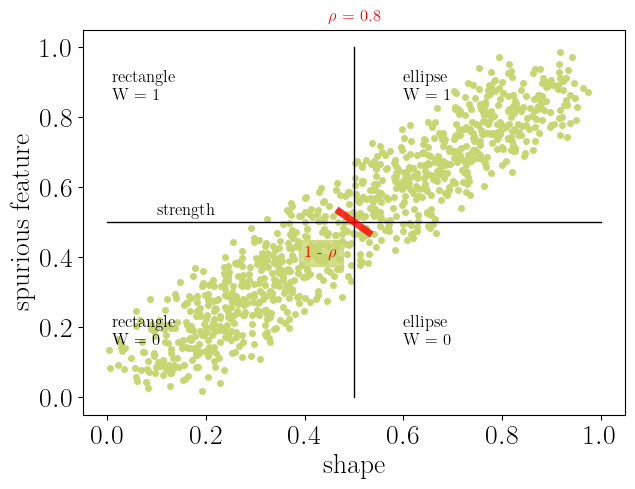

In [9]:
plot_fancy_distribution(bias=0.8, strength=0.5)